In [1]:
%matplotlib inline
import matplotlib as mpl
my_params = mpl.rcParams
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import folium
import datetime
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import scipy.stats
import itertools
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import calendar

In [2]:
zeist_SMAL_data = []
for json_path in glob.glob( 'N:\\air_zeist_data\\smal_zeist-export-month-2019-*.json'):
    with open(json_path) as f:
         zeist_SMAL_data += json.load(f)

In [3]:
wind_df  = pd.read_csv('N://air_zeist_data/KNMI_20191116_hourly.txt', sep=',',comment='#',index_col=None)
wind_df.head()

,STN,YYYYMMDD,HOUR,DDVEC,FHVEC
0,260,20190101,1,230,30
1,260,20190101,2,250,30
2,260,20190101,3,250,40
3,260,20190101,4,250,40
4,260,20190101,5,260,40


In [4]:
wind_df.tail()

,STN,YYYYMMDD,HOUR,DDVEC,FHVEC
7675,260,20191116,20,190,30
7676,260,20191116,21,190,30
7677,260,20191116,22,180,30
7678,260,20191116,23,200,20
7679,260,20191116,24,190,20


In [5]:
def convert_time_stamp(ts, hour):
    t = str(ts)
    year = int(t[:4])
    month = int(t[4:6])
    day = int(t[6:8])
    
    return datetime.datetime(year,month,day, hour-1)
#datetime.datetime.strptime( str(wind_df['YYYYMMDD'][0]), '%Y%MM%DD' )

In [6]:
wind_df['timestamp'] = [ convert_time_stamp(row['YYYYMMDD'], int(row['HOUR'])) for index,row in wind_df[ ['YYYYMMDD','HOUR'] ].iterrows()]

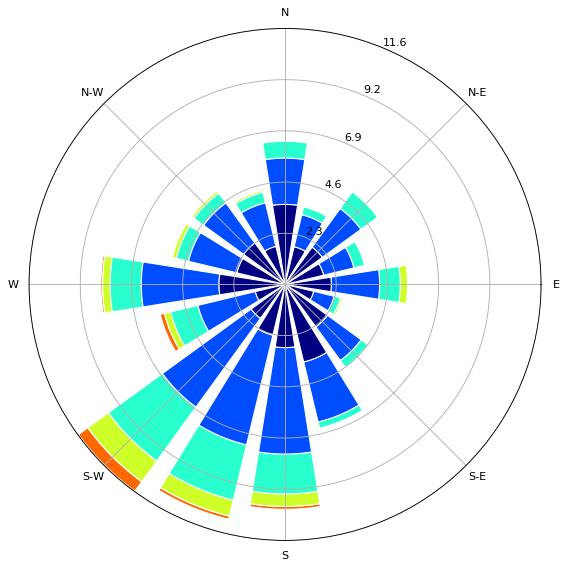

In [27]:
mpl.rcParams.update(mpl.rcParamsOrig)
mpl.rcParams.update(mpl.rcParamsDefault)


ax = WindroseAxes.from_ax()
ax.bar(wind_df['DDVEC'], wind_df['FHVEC'], normed=True, opening=0.8, edgecolor='white')

In [8]:
def get_id_list(data):
    set( [chunk.get('dev_id') for chunk in data] )
    

In [9]:
map_scat = folium.Map(location=(52.102374974638224, 5.241154683753848), zoom_start=14, width=800, height=600,max_zoom=60,tiles="Stamen Terrain")

In [10]:
[folium.CircleMarker( (x,y), radius=5,
                     fill=True,
                     
                     stroke=1,
                     opacity=1.0,
                     fill_opacity=0.8,
                color=(0,0,0),#cmapper(var, vCol, qf,pct),
                     
              fill_color='red').add_to(
    map_scat) 
 
  for x,y in [(52.102374974638224, 5.241154683753848)] # 
]

In [11]:
map_scat

In [12]:
def read_SMAL_timestamp(ts):
    time_string, time_zone = ts.split('+')
    dt = datetime.datetime.strptime( time_string.replace('.000',''),'%Y-%m-%dT%H:%M:%S' )
    dt += datetime.timedelta(hours= int( time_zone.split(':')[0] ) )
    return dt

In [13]:
select_station = 'seeeduino_lorawan_gps-6' 

In [14]:
# Extract all dust / moisture / temp data for one station

df_single_station = pd.DataFrame([ 
    
    {
        
     'pm10': chunk.get('pm10',{}).get('value', np.nan) ,
     'pm25': chunk.get('pm25',{}).get('value', np.nan) ,
     'rh': chunk.get('relative_humidity',{}).get('value', np.nan) ,
     'temp': chunk.get('temperature',{}).get('value', np.nan) ,
     'timestamp': read_SMAL_timestamp( chunk.get('timestamp') )
     
    }
                for chunk in zeist_SMAL_data if chunk.get('dev_id') == select_station
    ])

df_single_station.head()

,pm10,pm25,rh,temp,timestamp
0,6.58,3.08,65.67,18.17,2019-08-01 04:00:00
1,6.11,3.12,66.40,18.00,2019-08-01 04:10:00
2,6.71,3.30,67.01,17.96,2019-08-01 04:20:00
3,6.63,3.41,66.76,18.00,2019-08-01 04:30:00
4,7.29,3.68,67.15,17.95,2019-08-01 04:40:00


Text(0.5,0.98,'seeeduino_lorawan_gps-6')

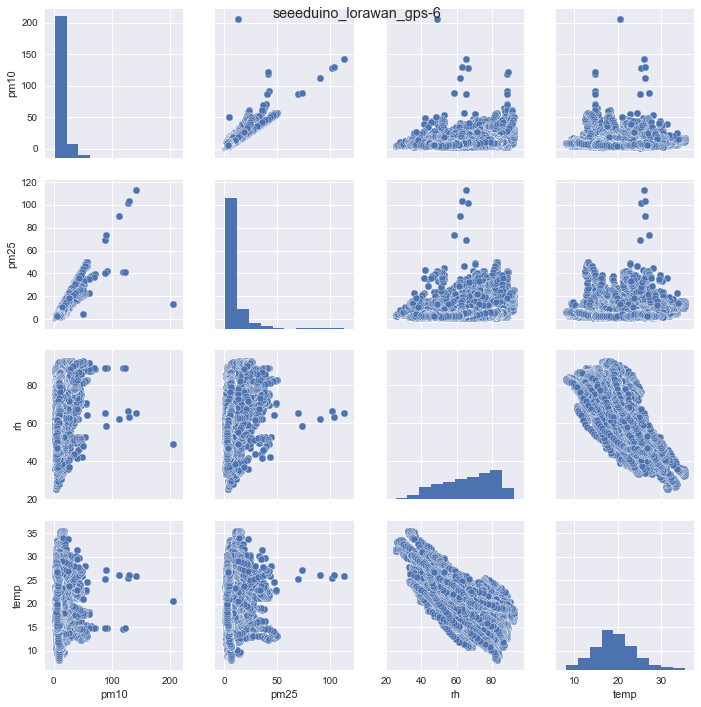

In [15]:
# Look at bias induced by moisture / temperature
sns.pairplot( df_single_station,size=2.5)
plt.suptitle(select_station)

In [16]:
# At high humidity the pm values are very high, which doesn't make sense,
# it means we can estimate the humidity when knowing the pm X

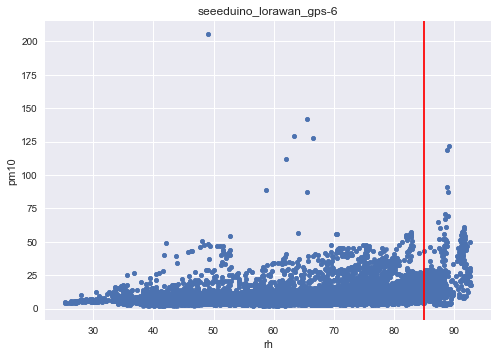

In [17]:
df_single_station.plot.scatter('rh','pm10')
plt.title(select_station)
# Above 85rh the sensor behaves very wonky
rh_upper_threshold = 85
plt.axvline(rh_upper_threshold,c='r')
#plt.yscale('log') 

In [18]:
df_single_station_filtered_rg = df_single_station [ df_single_station['rh'] <= rh_upper_threshold ]

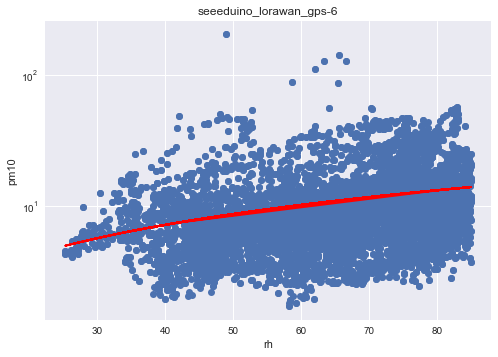

In [19]:
# Try to correct using linear fit
regression_x = 'rh'
regression_y = 'pm10'

df_single_station_filtered_rg.plot.scatter(regression_x,regression_y)
plt.yscale('log') 
plt.title(select_station)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    df_single_station_filtered_rg[regression_x],
    df_single_station_filtered_rg[regression_y])

plt.plot(df_single_station_filtered_rg[regression_x], df_single_station_filtered_rg[regression_y], 'o', label='original data')
plt.plot(df_single_station_filtered_rg[regression_x], intercept + slope*df_single_station_filtered_rg[regression_x], 'r', label='fitted line')


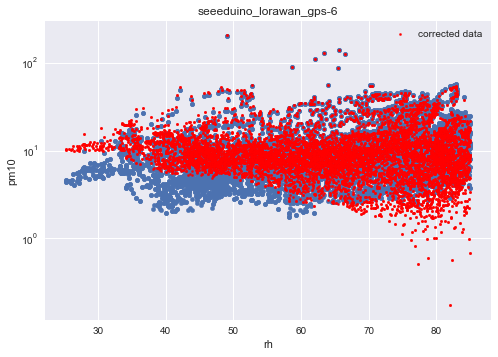

In [20]:
df_single_station_filtered_rg.plot.scatter(regression_x,regression_y)
plt.yscale('log') 
plt.title(select_station)

rg_corrected_data = df_single_station_filtered_rg.copy()
rg_corrected_data['pm10_corrected_rh'] = df_single_station_filtered_rg[regression_y].mean() + \
    df_single_station_filtered_rg[regression_y] - (intercept + slope*df_single_station_filtered_rg[regression_x])

plt.scatter(df_single_station_filtered_rg[regression_x], rg_corrected_data['pm10_corrected_rh'],
            c='r', label='corrected data',s=5)
plt.legend()

In [21]:
# 990 means no data or so
wind_df.loc[wind_df['DDVEC']==990,'DDVEC'] = np.nan

In [22]:
# Voeg een windrichting toe per dag
wind_with_matched_indices = wind_df.set_index('timestamp').reindex(rg_corrected_data.set_index('timestamp').index, method='nearest').reset_index()

In [23]:
combined_wind_and_sensor_data = wind_with_matched_indices.set_index('timestamp').join(rg_corrected_data.set_index('timestamp'))
combined_wind_and_sensor_data.head()

,STN,YYYYMMDD,HOUR,DDVEC,FHVEC,pm10,pm25,rh,temp,pm10_corrected_rh
timestamp,,,,,,,,,,
2019-08-01 04:00:00,260,20190801,5,180.0,30,6.58,3.08,65.67,18.17,6.396725
2019-08-01 04:10:00,260,20190801,5,180.0,30,6.11,3.12,66.40,18.00,5.816144
2019-08-01 04:20:00,260,20190801,5,180.0,30,6.71,3.30,67.01,17.96,6.323741
2019-08-01 04:30:00,260,20190801,6,190.0,30,6.63,3.41,66.76,18.00,6.281611
2019-08-01 04:40:00,260,20190801,6,190.0,30,7.29,3.68,67.15,17.95,6.882534


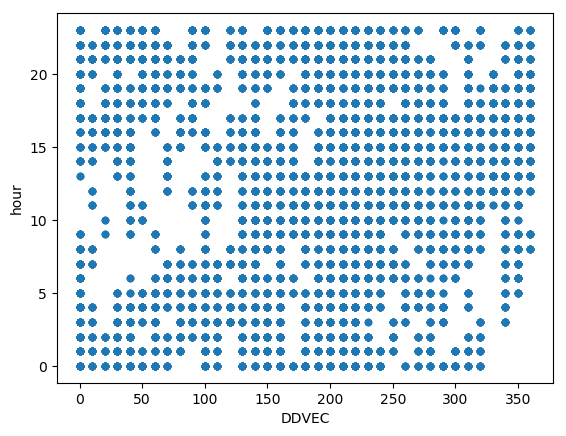

In [89]:
combined_wind_and_sensor_data.plot.scatter('DDVEC','hour')


In [100]:
# Drilldown to day of week + hour
combined_wind_and_sensor_data['hour'] = [ index.hour for index in combined_wind_and_sensor_data.index ]
combined_wind_and_sensor_data['day'] = [ index.weekday() for index in combined_wind_and_sensor_data.index ]
#Day starts with 0: monday
combined_wind_and_sensor_data['day name'] = [ calendar.day_abbr[index.weekday()] for index in combined_wind_and_sensor_data.index ]

combined_wind_and_sensor_data['day and hour'] = [ calendar.day_abbr[index.weekday()] + f' {index.hour:02d}:00' for index in combined_wind_and_sensor_data.index ]

# Remove rows where the wind direction is unknown:
combined_wind_and_sensor_data = combined_wind_and_sensor_data[~pd.isnull( combined_wind_and_sensor_data['DDVEC'] )]

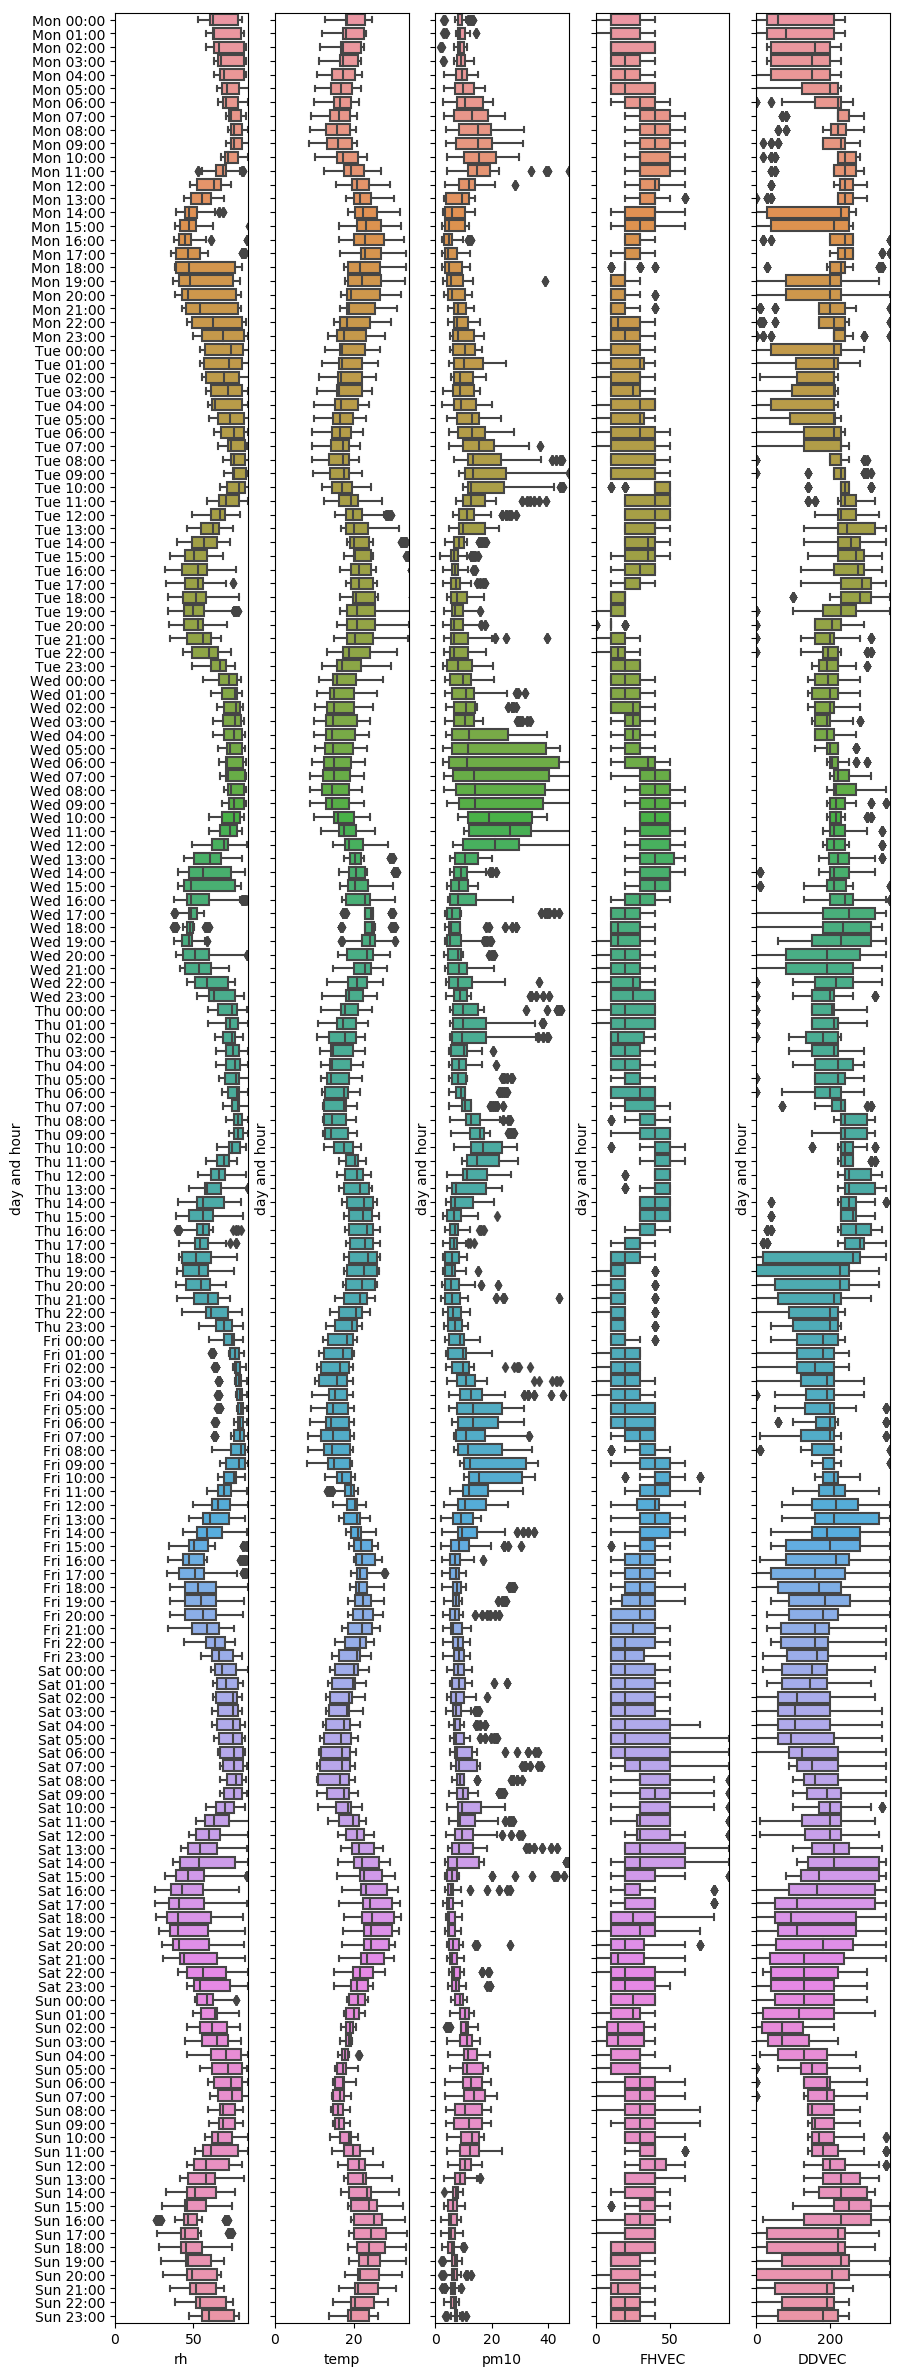

In [101]:
import seaborn as sns
selected_columns = ['rh','temp', 'pm10','FHVEC','DDVEC']
fig, axes = plt.subplots(1,len(selected_columns),figsize=(10,30),sharey=True)
for x_label,ax in zip(selected_columns,axes):

    sns.boxplot( ax=ax,
        data=combined_wind_and_sensor_data.sort_values(['day','hour']), 
        x=x_label, y='day and hour',orient='h'
    )
    #plt.gca() #.set_yscale('log')
    ax.set_xlim((0, np.percentile(combined_wind_and_sensor_data[x_label],99.5)))


KeyboardInterrupt: 

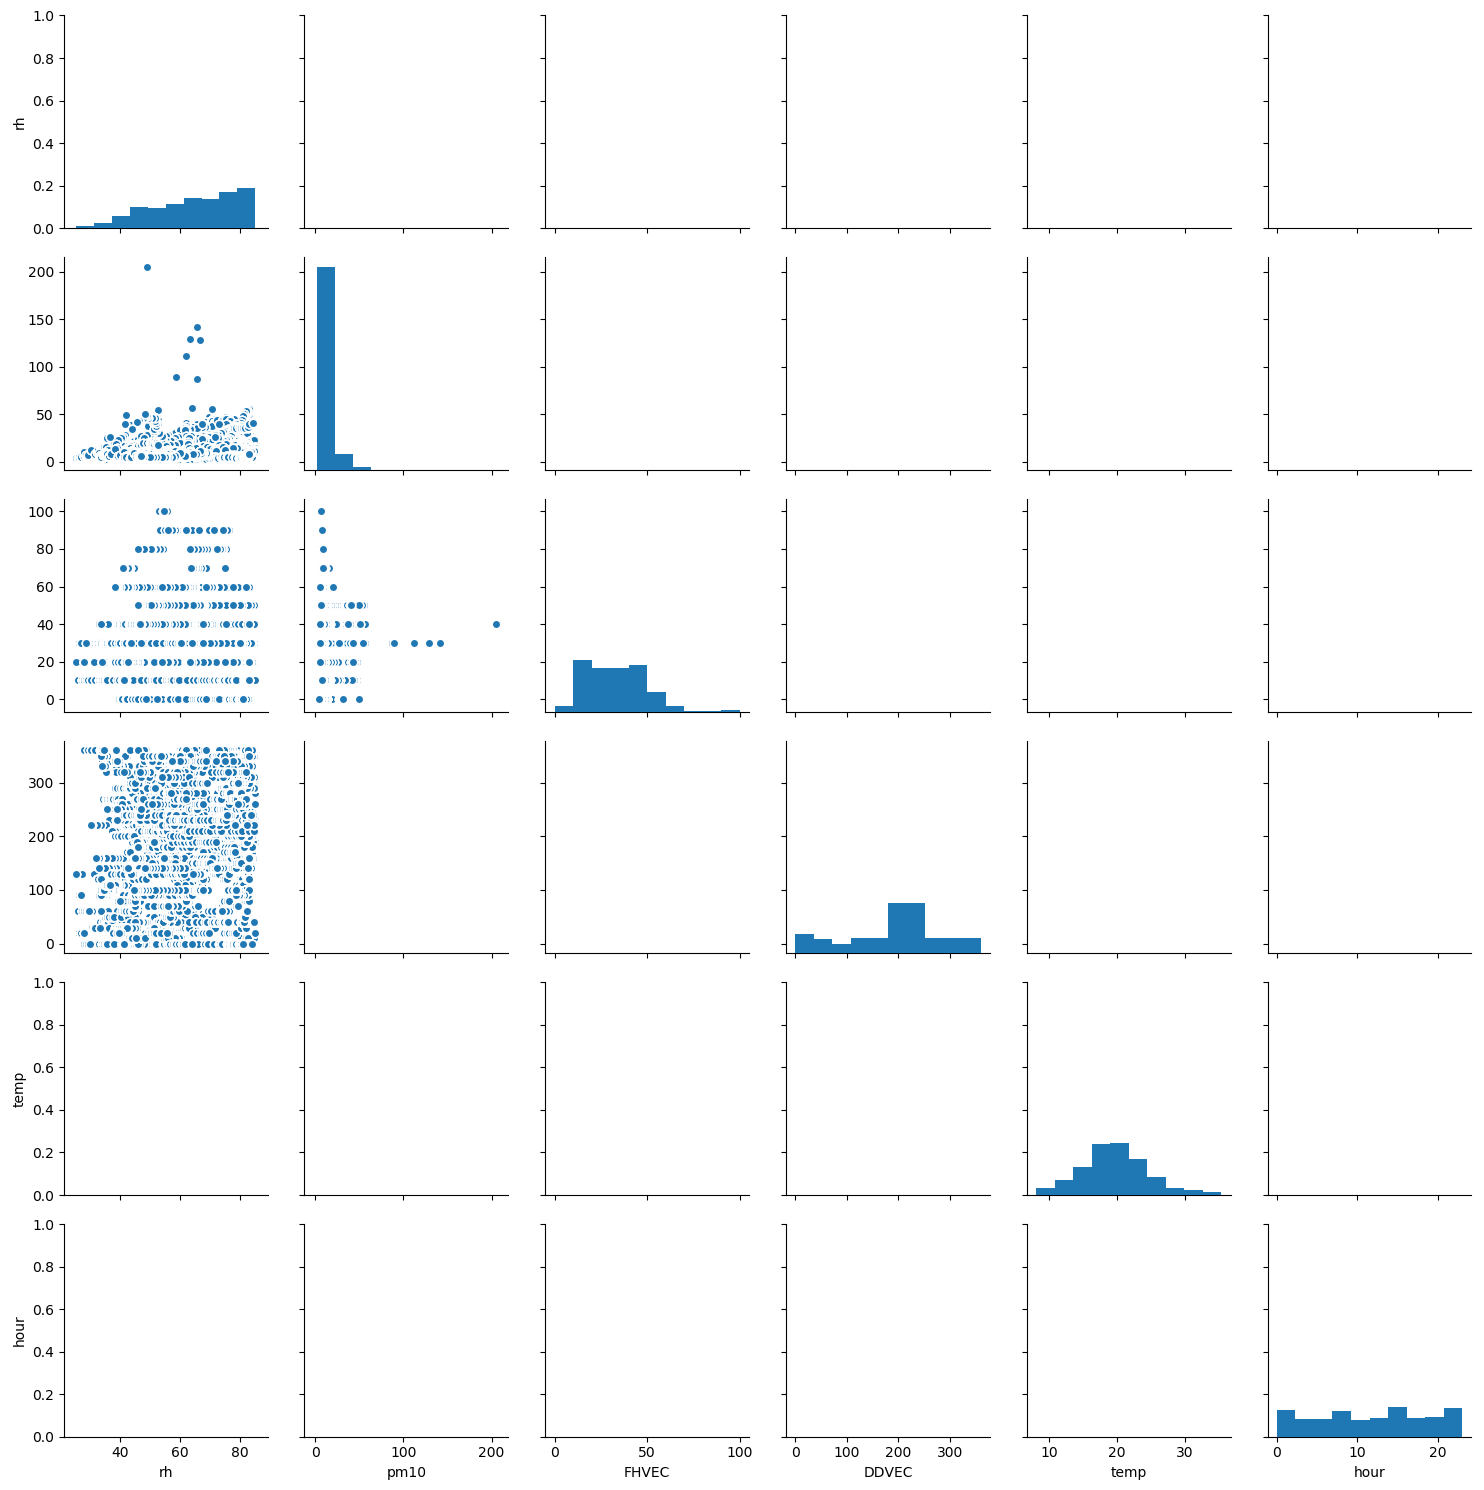

In [95]:
# Look at bias induced by moisture / temperature
columns =  ['rh','pm10','FHVEC','DDVEC','temp','hour']
sns.pairplot( combined_wind_and_sensor_data,size=2.5,x_vars=columns,y_vars=columns)
plt.suptitle(select_station)

In [84]:
mkdir wind_plots

In [96]:
mpl.rcParams.update(mpl.rcParamsOrig)
mpl.rcParams.update(mpl.rcParamsDefault)

for hour in range(0,24):
    #df = combined_wind_and_sensor_data[ combined_wind_and_sensor_data['hour']==9]
    df = combined_wind_and_sensor_data[ 
            (combined_wind_and_sensor_data['day']>0) &
            (combined_wind_and_sensor_data['day']<5) &
            (combined_wind_and_sensor_data['hour']==hour) 
    ] 
    ax = WindroseAxes.from_ax()
    ax.contourf(df['DDVEC'], 
           np.clip(df['pm10'], 0, np.percentile(combined_wind_and_sensor_data['pm10'],95)),
            bins=20 )
    ax.set_title(f'Mon-Fri {hour}')
    plt.savefig(f'./wind_plots/Mon-Fri_{hour}.png',dpi=200)
    plt.close()

In [ ]:
timefmt = '%Y-%m-%dT%H:%M:%S'
features = []

day = 0

for hour, day in itertools.product( range(23), range(7)):
    # Obtain mean value, and stdev per wind direction
    wind_direction_pm10 = pd.DataFrame({
        wind_dir: {
            'pm10_mean': wind_dir_data['pm10'].mean(),
            'pm10_stdev': wind_dir_data['pm10'].var(),
            'pm10_95pct': np.percentile( wind_dir_data['pm10'], 95)
        }
        for wind_dir, wind_dir_data in (
                combined_wind_and_sensor_data[ 
                    (combined_wind_and_sensor_data['day'] == day) &  (combined_wind_and_sensor_data['hour'] == hour)
                ]
        ).groupby('DDVEC')
    }).transpose()

    line_scale = 0.0005
    centroid = np.array( (52.102374974638224, 5.241154683753848) )

    
    for wind_direction, row in wind_direction_pm10.iterrows():
        #Wind coming from the north has a value of 0 or 360
        wind_direction_rad = wind_direction* np.pi / 180.0

        arrow_length= line_scale * row['pm10_mean'] #pm10_95pct

        target = np.array( (np.cos(wind_direction_rad)*arrow_length, np.sin(wind_direction_rad)*arrow_length) )

        points_mean = [ list(centroid), list(target+centroid) ]

        #folium.PolyLine(points, color="red" if wind_direction==9 else 'black', weight=2.5, opacity=1).add_to(map_wind)

        # Draw stdev:

        arrow_length= line_scale * row['pm10_mean']+ line_scale * row['pm10_stdev'] #pm10_95pct

        target = np.array( (np.cos(wind_direction_rad)*arrow_length, np.sin(wind_direction_rad)*arrow_length) )

        points_stdev = [ list(centroid), list(target+centroid) ]

        #pl = folium.PolyLine(points, color="red" if wind_direction==9 else 'black', weight=1, opacity=0.5).add_to(map_wind)
    
        start_time =(datetime.datetime(2019,11,4, 0)+ datetime.timedelta(days=day, hours=hour) ).strftime(timefmt) #.timestamp()*100 
        end_time =  (datetime.datetime(2019,11,4, 0)+ datetime.timedelta(days=day, hours=hour+1) ).strftime(timefmt)
        
        if sum(np.isnan( target+centroid ))==0:
            features.append(
            {
                'type': 'Feature',
                'geometry': {
                    'type': 'LineString',
                    'coordinates': [ list(reversed(list(centroid))), list(reversed(list(target+centroid))) ],
                },
                'properties': {
                    'times': [
                        start_time,end_time],
                    'style': {
                        'color': '#FF0000',
                        'weight': 5
                    }
                }
            })
        
    

In [ ]:
import folium.plugins

In [ ]:
map_wind = folium.Map(
        location=(52.102374974638224, 5.241154683753848),zoom_start=14, width=800, height=600,max_zoom=60,tiles="Stamen Terrain")


folium.plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT1H',duration='PT1H',
    
    add_last_point=True).add_to(map_wind)

map_wind

In [ ]:
m = folium.Map(
    location=(52.102374974638224, 5.241154683753848),
    zoom_start=16
)

folium.plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT1M', add_last_point=True).add_to(m)
m

In [ ]:
features

In [ ]:
import folium.plugins
folium.plugins.TimestampedGeoJson

In [ ]:
[{'geometry': {
    'coordinates': [[139.76451516151428, 35.68159659061569],[139.75964426994324, 35.682590062684206]],
   'type': 'LineString'},
  'properties': {'style': {'color': 'red', 'weight': 5},
   'times': ['2017-06-02T00:00:00', '2017-06-02T00:10:00']},

In [ ]:
features

In [ ]:
m = folium.Map(
    location=[35.68159659061569, 139.76451516151428],
    zoom_start=16
)

# Lon, Lat order.
lines = [
    {
        'coordinates': [
            [139.76451516151428, 35.68159659061569],
            [139.75964426994324, 35.682590062684206],
        ],
        'dates': [
            '2017-06-02T00:00:00',
            '2017-06-02T00:10:00'
        ],
        'color': 'red'
    },
    {
        'coordinates': [
            [139.75964426994324, 35.682590062684206],
            [139.7575843334198, 35.679505030038506],
        ],
        'dates': [
            '2017-06-02T00:10:00',
            '2017-06-02T00:20:00'
        ],
        'color': 'blue'
    },
    {
        'coordinates': [
            [139.7575843334198, 35.679505030038506],
            [139.76337790489197, 35.678040905014065],
        ],
        'dates': [
            '2017-06-02T00:20:00',
            '2017-06-02T00:30:00'
        ],
        'color': 'green',
        'weight': 15,
    },
    {
        'coordinates': [
            [139.76337790489197, 35.678040905014065],
            [139.76451516151428, 35.68159659061569],
        ],
        'dates': [
            '2017-06-02T00:30:00',
            '2017-06-02T00:40:00'
        ],
        'color': '#FFFFFF',
    },
]

features = [
    {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': line['coordinates'],
        },
        'properties': {
            'times': line['dates'],
            'style': {
                'color': line['color'],
                'weight': line['weight'] if 'weight' in line else 5
            }
        }
    }
    for line in lines
]

folium.plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='PT1M', add_last_point=True).add_to(m)
m

In [ ]:
features